<a href="https://colab.research.google.com/github/fubotz/ICL_2024W/blob/main/FinalProject_Fabian_SCHAMBECK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project: Finetuning a Multilingual Model
Description here...

Model:

Dataset:

In [25]:
!pip install bertviz
!pip install bertviz transformers
!pip install datasets
!pip install evaluate
!pip install transformers
!pip install torch

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 1: ##
Compute Cosine Similarity for cognates in pretrained model.

In [27]:
from bertviz import head_view, model_view
from transformers import AutoTokenizer, AutoModel

# Load the multilingual DistilBERT model and tokenizer
model_name = "distilbert/distilbert-base-multilingual-cased"
model = AutoModel.from_pretrained(model_name, output_attentions=True)

tokenizer = AutoTokenizer.from_pretrained(model_name)

print(tokenizer)

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-multilingual-cased', vocab_size=119547, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


In [28]:
# Define word pairs for cognate detection (n=21)
word_pairs = [
    ("academic", "académique"),
    ("administrator", "administrateur"),
    ("algorithm", "algorithme"),
    ("chemical", "chimique"),
    ("delicious", "délicieux"),
    ("emotion", "émotion"),
    ("exercise", "exercice"),
    ("gender", "genre"),
    ("gorilla", "gorille"),
    ("loyalty", "loyauté"),
    ("notation", "notamment"),
    ("objective", "objectif"),
    ("oratory", "oratoire"),
    ("particle", "particule"),
    ("quarter", "quartier"),
    ("september", "septembre"),
    ("skeleton", "squelette"),
    ("traditionally", "traditionnellement"),
    ("voice", "voix"),
    ("west", "ouest"),
    ("wine", "vin"),
]

In [33]:
import torch
from sklearn.metrics.pairwise import cosine_similarity

def get_embedding(text, level="word"):
    """
    Get the embedding for a word or sentence from the model.

    Parameters:
        text (str): The input text (word or sentence).
        level (str): The type of text ("word" or "sentence"), default is "word".

    Returns:
        torch.Tensor: The embedding for the text.
    """
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**tokens)
    embeddings = outputs.last_hidden_state

    # Use mean embedding for words, CLS token embedding for sentences
    if level == "word":
        return embeddings.mean(dim=1)       # mean for word embedding
    elif level == "sentence":
        return embeddings[:, 0, :]      # CLS token embedding


# Compute cosine similarity for cognates
results = []
for en, fr in word_pairs:
    en_emb = get_embedding(en)
    fr_emb = get_embedding(fr)
    similarity = cosine_similarity(en_emb.numpy(), fr_emb.numpy())[0][0]
    results.append((en, fr, similarity))

# Display the results
for en, fr, sim in results:
    print(f"{en} / {fr}: {sim:.4f}")

academic / académique: 0.5714
administrator / administrateur: 0.7124
algorithm / algorithme: 0.8960
chemical / chimique: 0.7135
delicious / délicieux: 0.6118
emotion / émotion: 0.6778
exercise / exercice: 0.7754
gender / genre: 0.5911
gorilla / gorille: 0.7855
loyalty / loyauté: 0.6725
notation / notamment: 0.6309
objective / objectif: 0.8733
oratory / oratoire: 0.8176
particle / particule: 0.7324
quarter / quartier: 0.7292
september / septembre: 0.8714
skeleton / squelette: 0.6438
traditionally / traditionnellement: 0.6676
voice / voix: 0.7951
west / ouest: 0.7790
wine / vin: 0.8487


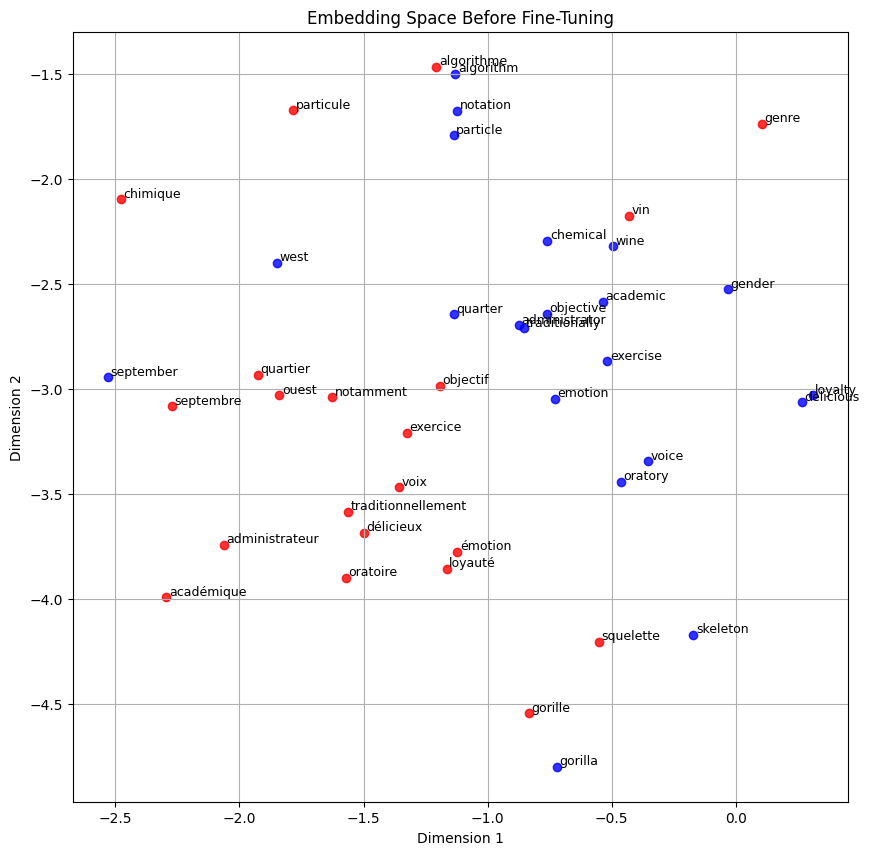

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Extract embeddings for all words
word_list = [word for pair in word_pairs for word in pair]
embeddings = [get_embedding(word).squeeze().numpy() for word in word_list]
embeddings = np.array(embeddings)

# Reduce dimensions with t-SNE (alternatively: PCA(n_components=2))
reducer = TSNE(n_components=2, random_state=42)
reduced_embeddings = reducer.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(10, 10))
colors = ["blue" if i % 2 == 0 else "red" for i in range(len(word_list))]       # English: blue, French: red

for i, word in enumerate(word_list):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], color=colors[i], alpha=0.8)
    plt.text(reduced_embeddings[i, 0] + 0.01, reduced_embeddings[i, 1] + 0.01, word, fontsize=9)

plt.title("Embedding Space Before Fine-Tuning")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()